# Przerwy energetyczne na podłożu GaSb:

Materiał: GaAlSb  
Podłoże: GaSb

#### Imports:

In [1]:
import os, re
import numpy as np
from mendeleev import element
from collections import Counter

from src.material_analysis import material_type_checker, binary_compounds_decomposition 
from src.utils import roman_to_int
from src.data_utils import read_binary_compounds_all_band_gaps

### Load material:

In [2]:
#material = 'GaAlGeSb'
material = 'AlGaSb'
ground_material = 'GaSb'

In [3]:
component_names = re.findall('[A-Z][^A-Z]*', material) 
print("Components: ", component_names)

Components:  ['Al', 'Ga', 'Sb']


In [4]:
material_type, material_type_extensive = material_type_checker(material)

print("Material type:", material_type)
print("Material type extensive:", material_type_extensive)

Material type: IIIA_VA
Material type extensive: IIIA_2_VA_1


In [5]:
compounds = binary_compounds_decomposition(material)
compounds

['AlSb', 'GaSb']

## Energy band characteristics:

### Band gaps in temperature of `300K` from mole fraction:

Read band gaps in `T=0K`:

In [6]:
params_file_path = os.path.join(".", "materials", "binary_compounds")

points_names = ['gamma', 'x', 'l']
egs_0k, alphas, betas = read_binary_compounds_all_band_gaps(compounds, params_file_path, points_names)
egs_0k, alphas, betas

(array([[2.386, 1.696, 2.329],
        [0.812, 1.141, 0.875]]),
 array([[0.00042 , 0.00039 , 0.00058 ],
        [0.000417, 0.000475, 0.000597]]),
 array([[140., 140., 140.],
        [140.,  94., 140.]]))

Calculate the band gaps in `T=300K`:

In [20]:
def calculating_bandgaps_from_varshni_relation(eg_0k, a, b, t=300):
    eg_t = eg_0k-(a*t**2)/(t+b)
    return eg_t 
    
egs_300k = []
for i, c in enumerate(compounds):
    c_egs_300k = []
    for eg, a, b in zip(egs_0k[i], alphas[i], betas[i]):
        c_egs_300k.append(calculating_bandgaps_from_varshni_relation(eg, a, b, t=300))
    egs_300k.append(c_egs_300k)

egs_300k = np.array(egs_300k)
egs_300k

array([[2.30009091, 1.61622727, 2.21036364],
       [0.72670455, 1.03249746, 0.75288636]])

Import simulation method:

In [15]:
import importlib

try:
    libname = ".".join(["src", "simulations", material_type])
    simulation = importlib.import_module(libname)
    simulation = importlib.reload(simulation)
except ImportError:
    simulation = None
    print(f'Simulation method for \'{material_type}\' not implemented.')
else:
    globals()[libname] = simulation

Calculate bandgap from mole fractions:

In [16]:
params_file_path = os.path.join(".", "materials", "ternary_alloys")

bowing_parameters = []
for point in points_names:
    bowing_parameters.append(read_alloys_param(material, params_file_path, f'C_Eg_{point}'))
    
bowing_parameters

[[-0.044, 1.22], 0.0, 0.0]

In [32]:
Eg_x = []
x = []
for i, point in enumerate(points_names):
    calc_params = {"bowing_parameters": bowing_parameters[i]}
    x, point_Eg_x = simulation.band_gap_from_mole_fraction(egs_300k[:,i], 
                                                           material_type_extensive, 
                                                           calc_params=calc_params, 
                                                           method="VCA", 
                                                           points=20)
    Eg_x.append(point_Eg_x)

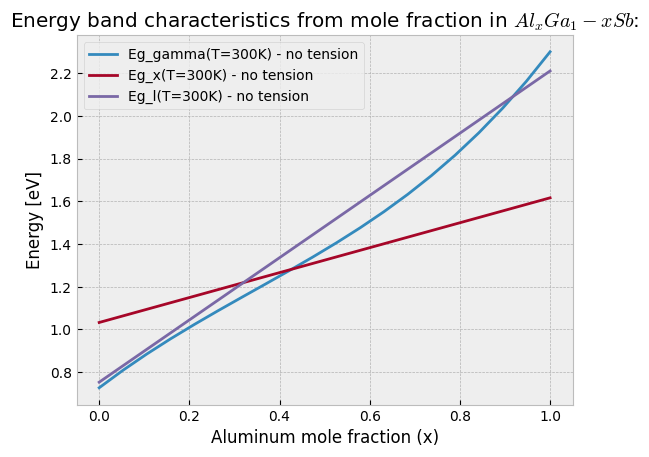

In [38]:
import matplotlib.pyplot as plt


with plt.style.context("bmh"):
    fig, ax = plt.subplots(1,1)
    for i, point in enumerate(points_names):
        ax.plot(x, Eg_x[i], '-', label=f'Eg_{point}(T=300K) - no tension')
    
    ax.set_title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    ax.set_ylabel("Energy [eV]")
    ax.set_xlabel(f'{element(component_names[0]).name} mole fraction (x)')
    
    plt.legend()
    plt.show()